# Directrices del proyecto - CENTRO DE ACOPIO AGRÍCOLA

El objetivo es:

1. **Seleccionar el municipio más adecuado basándose en un análisis espacial bien estructurado y reproducible.
2. **Dentro del municipio seleccionado, identificar y cartografiar la mejor zona local (polígono) donde debería implantarse el proyecto (centro de acopio agrícola).


El resultado final incluirá, por tanto, dos niveles de análisis::

- Nivel 1 — Clasificación de municipios basada en el análisis multicriterio.
- Nivel 2 - Análisis espacial intramunicipal para identificar la mejor ubicación dentro del municipio seleccionado.

## Importar Librarias

In [294]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

plt.rcParams['figure.figsize'] = (10, 8)

## Preparación de datos y CRS


### Cargar y armonizar los datos

Importamos los cinco ficheros fuente, ordenamos algunas columnas y
nos aseguramos de que **cada capa espacial** se proyecta a *MAGNA-SIRGAS Origen Nacional*
(**EPSG 9377**).  
La tabla EVA no tiene coordenadas, pero renombramos su código de municipio
a `cod_mun` por coherencia.Data preparation & CRS
Todas las capas espaciales deben ser reproyectadas a EPSG 9377.
Documente cualquier limpieza, preprocesamiento o transformación CRS que realice.



In [295]:
# --- File paths  ---
root_folder=r"Datos"

SHAPE_MUN = root_folder+'/Municipios/municipios_colombia.shp'
SHAPE_RUNAP = root_folder+'/latest/runap.shp'
SHAPE_VIAS = root_folder+'/vias/vias.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'


In [296]:
# Municipalities, protect areas and roats → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)
gdf_runap = gpd.read_file(SHAPE_RUNAP).to_crs(epsg=9377)
gdf_vias = gpd.read_file(SHAPE_VIAS).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "MPIO_CCDGO", "CÓD. \nDEP.": "DPTO_CCDGO"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["Codigo_Mun"].astype(str).str.zfill(5)
gdf_mun["DPTO_CCDGO"] = gdf_mun["DPTO_CCDGO"].astype(str).str.zfill(2)
eva["MPIO_CCDGO"]        = eva["MPIO_CCDGO"].astype(str).str.zfill(5)

print(gdf_mun.head())

1,122 municipalities • 8,973 stations • 206,068 EVA rows
  DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0         18      18001               FLORENCIA      18001     2018   
1         18      18029                 ALBANIA      18029     2018   
2         18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3         18      18247             EL DONCELLO      18247     2018   
4         18      18256               EL PAUJÍL      18256     2018   

           AREA   LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  STP51_PRIM  \
0  2.547638e+09  1.749139 -75.558239     71877.0       32.0  ...     48848.0   
1  4.141221e+08  1.227865 -75.882327      2825.0       24.0  ...      1940.0   
2  1.191619e+09  1.500923 -75.875645      4243.0       54.0  ...      3541.0   
3  1.106076e+09  1.791386 -75.193944      8809.0        0.0  ...      7571.0   
4  1.234734e+09  1.617746 -75.234043      5795.0        0.0  ...      6072.0   

   STP51_SECU  STP51_SUPE  STP51_PO

In [298]:
# Crear tabla única de departamentos con código y nombre
deptos = eva[["DPTO_CCDGO", "DEPARTAMENTO"]].drop_duplicates()
deptos["DPTO_CCDGO"] = deptos["DPTO_CCDGO"].astype(str).str.zfill(2)

# añadir nombre del departamento a los municipios
gdf_mun = gdf_mun.merge(deptos, on="DPTO_CCDGO", how="left")
print(gdf_mun)

     DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0            18      18001               FLORENCIA      18001     2018   
1            18      18029                 ALBANIA      18029     2018   
2            18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3            18      18247             EL DONCELLO      18247     2018   
4            18      18256               EL PAUJÍL      18256     2018   
...         ...        ...                     ...        ...      ...   
1117         25      25290              FUSAGASUGÁ      25290     2018   
1118         25      25662     SAN JUAN DE RIOSECO      25662     2018   
1119         73      73349                   HONDA      73349     2018   
1120         05      05631                SABANETA       5631     2018   
1121         05      05380             LA ESTRELLA       5380     2018   

              AREA   LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  \
0     2.547638e+09  1.749139 -75.558239 

##  Análisis multicriterio - Nivel 1

### Selección de municipio

- Se realizó un *filtrado espacial* para delimitar el área de análisis a los departamentos que conforman la región Amazónica, definida como el centro focal del estudio para la identificación de un centro de acopio agrícola.
- A partir de esta delimitación, se establecieron criterios para determinar la zona óptima dentro de esta región. Esta zona debía cumplir con condiciones clave como: *alta accesibilidad* (proximidad a vías principales), *diversidad de productos agrícolas*, *buena productividad agropecuaria*, *presencia de estaciones meteorológicas* y *densidad poblacional* que faciliten el monitoreo climático.
- Estos criterios se integraron en un análisis multicriterio espacial con el fin de identificar áreas que maximicen el potencial logístico, productivo y ambiental para el establecimiento del centro de acopio.

In [299]:
# Filtrar municipios amazónicos
departamentos_amazonia = ["AMAZONAS", "CAQUETA", "GUAVIARE", "GUAINIA", "PUTUMAYO", "VAUPES"]
gdf_mun_amz = gdf_mun[gdf_mun["DEPARTAMENTO"].isin(departamentos_amazonia)].copy()
print(gdf_mun_amz)

    DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0           18      18001               FLORENCIA      18001     2018   
1           18      18029                 ALBANIA      18029     2018   
2           18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3           18      18247             EL DONCELLO      18247     2018   
4           18      18256               EL PAUJÍL      18256     2018   
5           18      18410            LA MONTAÑITA      18410     2018   
6           18      18460                   MILÁN      18460     2018   
7           18      18479                 MORELIA      18479     2018   
8           18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9           18      18860              VALPARAÍSO      18860     2018   
10          18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11          18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12          18      18756                  SOLANO  

#### - Calculamos la densidad poblacional a partir del atributo *STP27_PERS*

Con el fin de incorporar un criterio demográfico en el análisis de aptitud territorial, se calculó la *densidad poblacional* de cada municipio dentro del área de estudio. Para ello, se empleó el atributo STP27_PERS, correspondiente a la población total reportada por municipio.

Primero, se calculó el área de cada municipio en kilómetros cuadrados, dividiendo el área en metros cuadrados (geometry.area) entre 1 millón. Posteriormente, la densidad poblacional fue estimada como el cociente entre la población total (STP27_PERS) y el área en km², generando así un nuevo campo denominado pop_density_km2.

Este indicador permitió visualizar y comparar la concentración poblacional en los municipios amazónicos, contribuyendo a identificar aquellas zonas con mayor presencia humana, lo cual puede ser relevante para la ubicación estratégica de un centro de acopio.

In [300]:
# calcular densidad poblacional por municipio
gdf_mun_amz['area_km2'] = gdf_mun_amz.area / 1e6
gdf_mun_amz["pop_density_km2"] = gdf_mun_amz["STP27_PERS"]/ gdf_mun_amz['area_km2']

print(gdf_mun_amz)

    DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0           18      18001               FLORENCIA      18001     2018   
1           18      18029                 ALBANIA      18029     2018   
2           18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3           18      18247             EL DONCELLO      18247     2018   
4           18      18256               EL PAUJÍL      18256     2018   
5           18      18410            LA MONTAÑITA      18410     2018   
6           18      18460                   MILÁN      18460     2018   
7           18      18479                 MORELIA      18479     2018   
8           18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9           18      18860              VALPARAÍSO      18860     2018   
10          18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11          18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12          18      18756                  SOLANO  

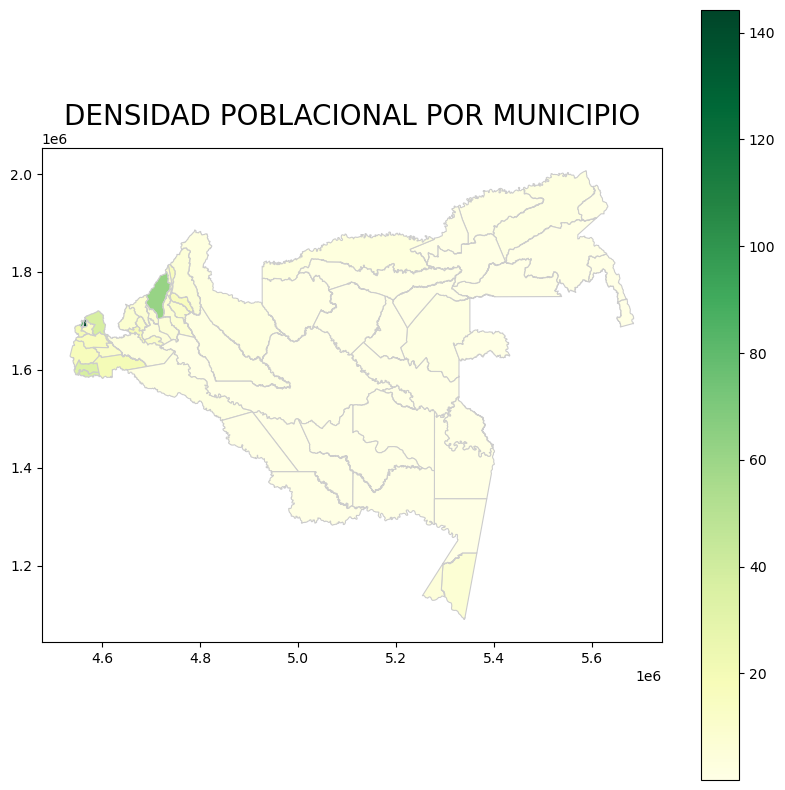

In [301]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="pop_density_km2", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)

# Títulos y estilo
ax.set_title("DENSIDAD POBLACIONAL POR MUNICIPIO", fontsize=20)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

plt.show()

#### - Calculamos la densidad de las vías por municipio
Con el propósito de evaluar el nivel de accesibilidad vial como uno de los criterios clave para la localización del centro de acopio agrícola, se estimó la densidad de vías dentro de cada municipio de la región amazónica.

Los pasos seguidos fueron los siguientes:

1. Intersección espacial entre vías y municipios:
Se realizó una operación espacial de tipo intersection entre la capa de vías (gdf_vias) y la capa de municipios amazónicos (gdf_mun_amz) para identificar únicamente los segmentos de vía contenidos dentro de los límites municipales.

2. Cálculo de la longitud vial:
A cada segmento de vía resultante de la intersección se le calculó su longitud en metros mediante la propiedad geometry.length.

3. Agregación por municipio:
Se agruparon las longitudes por municipio utilizando el código municipal (MPIO_CCDGO) como clave, y se sumó la longitud total de vías por cada unidad territorial.

4. Unión con la capa de municipios:
La longitud total de vías por municipio se integró nuevamente al GeoDataFrame de municipios mediante una operación merge. En los casos donde no se registraron vías (i.e., intersección vacía), se asignó un valor de 0.

5. Cálculo de la densidad vial:
Finalmente, se calculó la densidad de vías como la longitud total de vías (en metros) dividida por el área del municipio (en km²), generando un nuevo atributo denominado vias_km2.

In [302]:
# 1. Intersectar las vias con los municipios -> GDF
vias_en_mun = gpd.overlay(gdf_vias, gdf_mun_amz, how="intersection")

# 2. Calcular longintud de las vías
vias_en_mun["long_m"] = vias_en_mun.geometry.length

# 3. Agrupar por municipio
long_vias = vias_en_mun.groupby("MPIO_CCDGO")[["long_m"]].sum().reset_index()

# Calcular área de cada municipio (en m²)
gdf_mun_amz["area_m2"] = gdf_mun_amz.geometry.area

long_vias = long_vias.rename(columns={"long_m": "long_m_vias"})

# 4. Hacer merge de la longitud con el GDF de municipios
gdf_mun_amz = gdf_mun_amz.merge(long_vias, on="MPIO_CCDGO", how="left")
gdf_mun_amz["long_m_vias"] = gdf_mun_amz["long_m_vias"].fillna(0) # Rellenar con 0 los municipios sin vías

# 5. Calcular densidad de vías (por km²)
gdf_mun_amz["vias_km2"] = gdf_mun_amz["long_m_vias"] / (gdf_mun_amz["area_m2"] / 1e6)
# print(gdf_mun_amz)
gdf_mun_amz

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DEPARTAMENTO,area_km2,pop_density_km2,area_m2,long_m_vias,vias_km2
0,18,18001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",CAQUETA,2546.958298,61.559312,2.546958e+09,95033.941548,37.312720
1,18,18029,ALBANIA,18029,2018,4.141221e+08,1.227865,-75.882327,2825.0,24.0,...,1.112829,0.033618,18029,"POLYGON ((4677933.827 1709133.846, 4677934.064...",CAQUETA,414.100691,10.900730,4.141007e+08,1235.940605,2.984638
2,18,18094,BELÉN DE LOS ANDAQUÍES,18094,2018,1.191619e+09,1.500923,-75.875645,4243.0,54.0,...,2.234657,0.096745,18094,"POLYGON ((4690015.614 1751610.86, 4690005.125 ...",CAQUETA,1191.551389,7.616121,1.191551e+09,22778.780336,19.116910
3,18,18247,EL DONCELLO,18247,2018,1.106076e+09,1.791386,-75.193944,8809.0,0.0,...,3.154370,0.089867,18247,"POLYGON ((4737450.122 1814755.048, 4737477.663...",CAQUETA,1105.514836,16.078482,1.105515e+09,26060.640601,23.573307
4,18,18256,EL PAUJÍL,18256,2018,1.234734e+09,1.617746,-75.234043,5795.0,0.0,...,3.529316,0.100309,18256,"POLYGON ((4736905.653 1802381.382, 4737650.731...",CAQUETA,1234.140645,10.544989,1.234141e+09,18564.392925,15.042364
5,18,18410,LA MONTAÑITA,18410,2018,1.701061e+09,1.302860,-75.235727,5113.0,15.0,...,3.402939,0.138174,18410,"POLYGON ((4732709.921 1753612.108, 4733113.179...",CAQUETA,1700.246212,7.133085,1.700246e+09,23667.998363,13.920336
6,18,18460,MILÁN,18460,2018,1.220576e+09,1.146693,-75.386648,3462.0,363.0,...,1.863197,0.099128,18460,"POLYGON ((4733752.837 1708152.838, 4733760.752...",CAQUETA,1220.112914,6.152709,1.220113e+09,0.000000,0.000000
7,18,18479,MORELIA,18479,2018,4.624796e+08,1.382996,-75.673811,1907.0,0.0,...,1.518688,0.037554,18479,"POLYGON ((4691680.95 1732813.818, 4691743.086 ...",CAQUETA,462.391875,7.244937,4.623919e+08,6895.323345,14.912293
8,18,18610,SAN JOSÉ DEL FRAGUA,18610,2018,1.304769e+09,1.304702,-76.110006,5756.0,83.0,...,2.040837,0.105893,18610,"POLYGON ((4647662.862 1733719.27, 4647740.381 ...",CAQUETA,1304.898166,8.708726,1.304898e+09,9972.833257,7.642614
9,18,18860,VALPARAÍSO,18860,2018,1.330210e+09,1.061292,-75.627048,3958.0,0.0,...,2.313848,0.108006,18860,"POLYGON ((4696163.446 1704876.824, 4696219.718...",CAQUETA,1329.917002,4.573218,1.329917e+09,1071.303575,0.805542


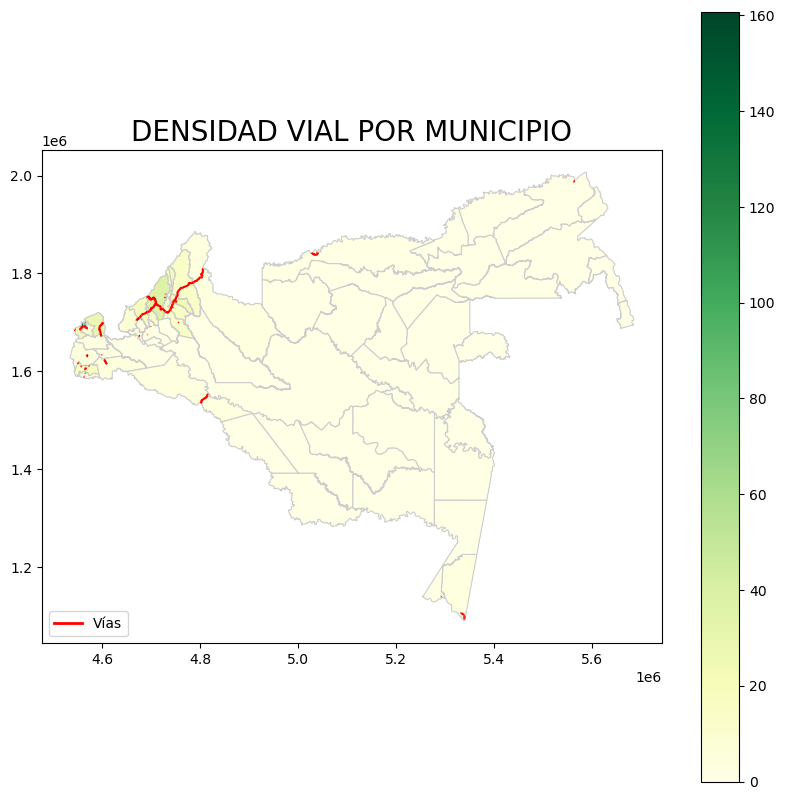

In [303]:
from matplotlib.lines import Line2D
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="vias_km2", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
vias_en_mun.plot(ax=ax, edgecolor='red');
# 4. Títulos y estilo
ax.set_title("DENSIDAD VIAL POR MUNICIPIO", fontsize=20)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

# Crear leyenda manual para las vías
leyenda_vias = [Line2D([0], [0], color='red', lw=2, label='Vías')]

# Mostrar leyenda
ax.legend(handles=leyenda_vias, loc='lower left')

plt.show()

#### - Cálculo de la proporción de áreas protegidas (RUNAP) por municipio
Con el objetivo de identificar la presencia y extensión relativa de áreas protegidas en cada municipio, se realizó el siguiente procedimiento:

1. Intersección espacial entre municipios y áreas protegidas:
Se utilizó la función overlay de geopandas para obtener las zonas de superposición entre los polígonos de municipios (gdf_mun_amz) y las áreas protegidas pertenecientes al Registro Único Nacional de Áreas Protegidas (RUNAP) (gdf_runap).

2. Cálculo del área de intersección:
A cada polígono resultante de la intersección se le calculó su área en kilómetros cuadrados (area_runap_km2).

3. Agregación por municipio:
Las áreas protegidas fueron sumadas por municipio (MPIO_CCDGO) para obtener el área total de RUNAP dentro de cada unidad administrativa.

4. Unión de datos al GeoDataFrame principal:
Se realizó un merge con el GeoDataFrame de municipios (gdf_mun_amz) para incorporar la variable area_runap_km2. En los casos donde no hubo intersección con RUNAP, se asignó un valor de 0.

5. Cálculo de la proporción de área protegida:
Finalmente, se calculó la proporción de área protegida dentro de cada municipio (proporcion_runap) como el cociente entre el área protegida y el área total del municipio en km².

In [304]:
# 1. spatial intersection
interseccion_runap = gpd.overlay(gdf_mun_amz, gdf_runap, how='intersection')

# 2. Calculate the area of the intersection
interseccion_runap["area_runap_km2"] = interseccion_runap.geometry.area/ 1e6

# 3. Groupby municipality and add the protected areas
runap_por_mun = interseccion_runap.groupby("MPIO_CCDGO")[["area_runap_km2"]].sum().reset_index()

# 4. Join to GeoDataFrame of municipalities
gdf_mun_amz = gdf_mun_amz.merge(runap_por_mun, on="MPIO_CCDGO", how="left").fillna(0) # Rellenar con 0 los municipios sin runap

# 5. Percentage of runap by municipality
gdf_mun_amz["proporcion_runap"] = gdf_mun_amz["area_runap_km2"] / (gdf_mun_amz["area_m2"] / 1e6)
print(gdf_mun_amz)

/tmp/ipykernel_43/787912538.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1728 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  interseccion_runap = gpd.overlay(gdf_mun_amz, gdf_runap, how='intersection')


   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

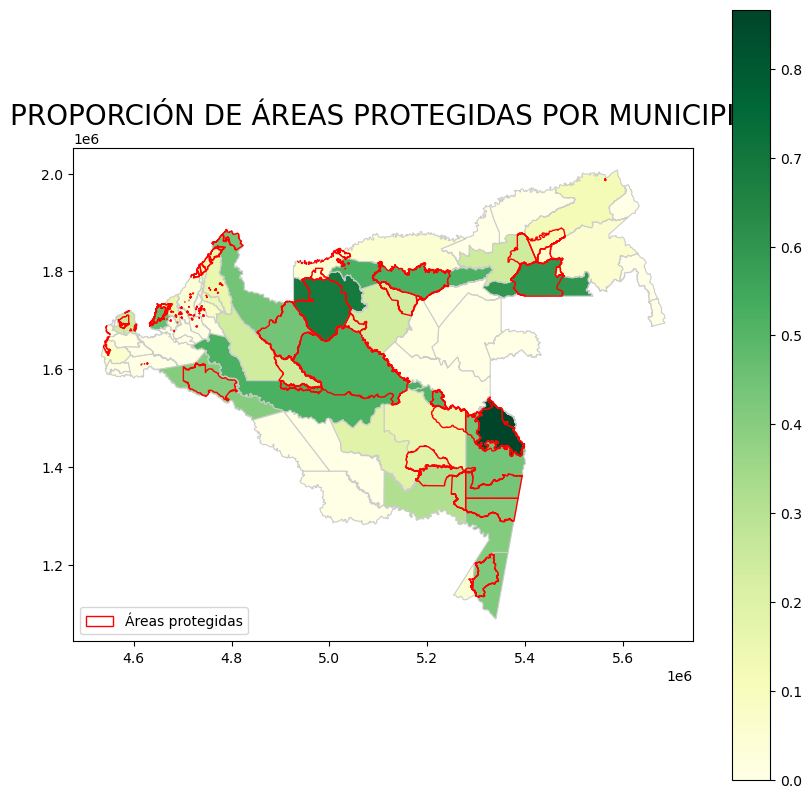

In [305]:
import matplotlib.patches as mpatches

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="proporcion_runap", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
interseccion_runap.plot(ax=ax, color='None', edgecolor='red');
# 4. Títulos y estilo
ax.set_title("PROPORCIÓN DE ÁREAS PROTEGIDAS POR MUNICIPIO", fontsize=20)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

# Crear leyenda personalizada
runap_patch = mpatches.Patch(edgecolor='red', facecolor='none', label='Áreas protegidas')
ax.legend(handles=[runap_patch], loc='lower left') 

plt.show()

#### -  Conteo de estaciones meteorológicas por municipio
Para evaluar la proximidad a fuentes de información climática como criterio de localización, se calculó el número de estaciones meteorológicas presentes en cada municipio de la Amazonía:

1. Intersección espacial (spatial join) entre estaciones y municipios:
Se utilizó sjoin de geopandas con el parámetro predicate="within" para identificar las estaciones (gdf_est) que se encuentran dentro de los límites de cada municipio (gdf_mun_amz).

2. Conteo de estaciones por municipio:
A partir del GeoDataFrame resultante (est_en_mun), se contabilizó cuántas estaciones hay en cada municipio (MPIO_CCDGO), generando la variable n_estaciones.

3. Unión con el GeoDataFrame de municipios:
Los conteos se unieron nuevamente a gdf_mun_amz mediante un merge. En los municipios sin estaciones se asignó un valor de 0 con fillna(0).

In [306]:
# 1. stations within each municipality
est_en_mun = gpd.sjoin(gdf_est, gdf_mun_amz, how="inner", predicate="within")

# 2. Count stations by municipality
conteo_est = est_en_mun.groupby("MPIO_CCDGO").size().reset_index(name="n_estaciones")

# 3. Merge with municipalities
gdf_mun_amz = gdf_mun_amz.merge(conteo_est, on="MPIO_CCDGO", how="left")
gdf_mun_amz["n_estaciones"] = gdf_mun_amz["n_estaciones"].fillna(0)
print(gdf_mun_amz)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

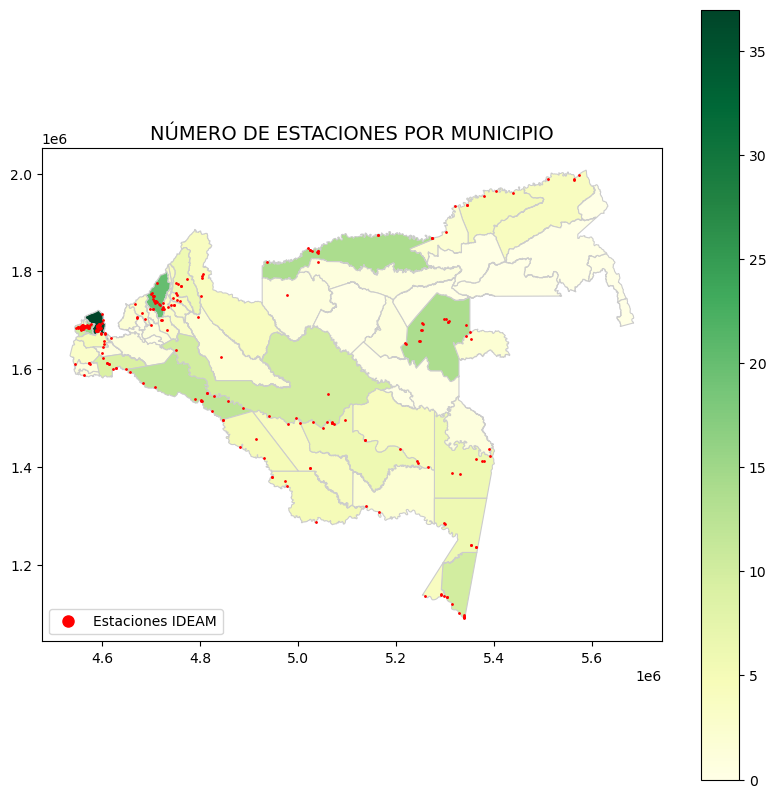

In [307]:
import matplotlib.lines as mlines

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="n_estaciones", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
est_en_mun.plot(ax=ax, color="red", markersize=1);
# 4. Títulos y estilo
ax.set_title("NÚMERO DE ESTACIONES POR MUNICIPIO", fontsize=14)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

# Crear leyenda personalizada para puntos
est_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                           markersize=8, label='Estaciones IDEAM')

# Agregar leyenda al mapa
ax.legend(handles=[est_legend], loc='lower left')

plt.show()

#### 🌾 Producción agrícola y diversidad de cultivos por municipio
Para incorporar criterios agroproductivos en la selección del municipio más adecuado para ubicar un centro de acopio, se realizó un análisis sobre la producción y la variedad de cultivos usando la capa EVA:

1. Producción total por municipio:
Se agruparon los datos de la capa EVA por el código de municipio (MPIO_CCDGO) y se sumaron los valores de la columna "Producción\n(t)", obteniendo la producción total en toneladas por municipio.

2. Variedad de cultivos por municipio:
Se calculó el número de cultivos distintos registrados en EVA para cada municipio con .nunique() sobre la columna CULTIVO.

3. Unión de ambas métricas:
Se integraron ambas variables en un solo DataFrame y luego se unieron a gdf_mun_amz. Se usó .fillna(0) para asignar cero en los municipios que no reportan producción agrícola en la capa EVA.

In [308]:
# 1. produccion por municipio
prod_mun = eva.groupby("MPIO_CCDGO")[["Producción\n(t)"]].sum().reset_index()

# 2. variedad de cultivos por munnicipio
n_cultivos = eva.groupby("MPIO_CCDGO")["CULTIVO"].nunique().reset_index()
n_cultivos.columns = ["MPIO_CCDGO", "n_cultivos"]

# 3. Unir resultados
prod_mun = prod_mun.merge(n_cultivos, on="MPIO_CCDGO", how="left").fillna(0)
gdf_mun_amz = gdf_mun_amz.merge(prod_mun, on="MPIO_CCDGO", how="left").fillna(0)

print(gdf_mun_amz)


   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

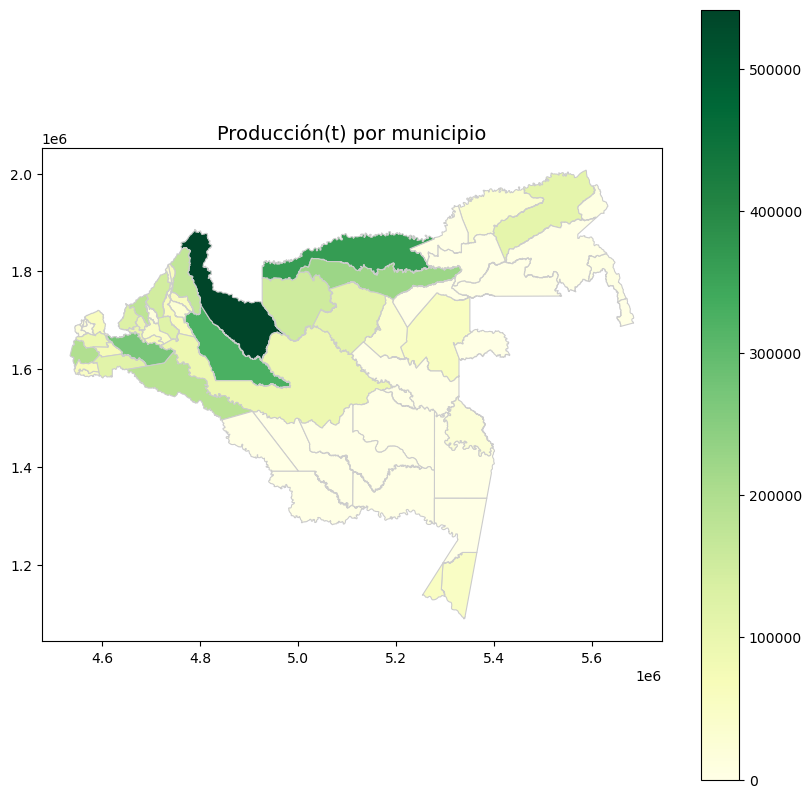

In [309]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="Producción\n(t)", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)

# 4. Títulos y estilo
ax.set_title("Producción(t) por municipio", fontsize=14)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

plt.show()

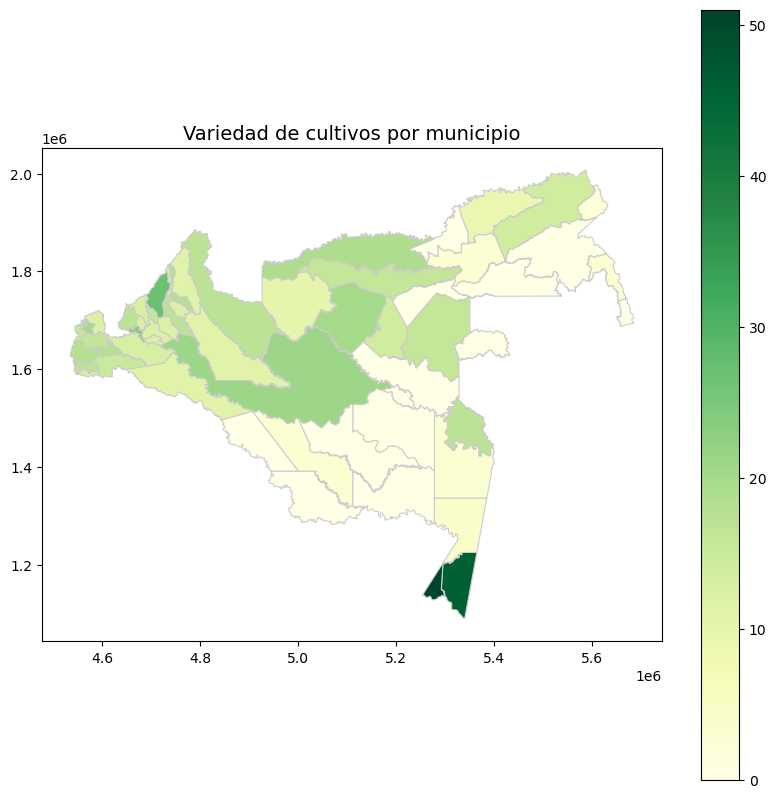

In [310]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_mun_amz.plot(column="n_cultivos", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)

# 4. Títulos y estilo
ax.set_title("Variedad de cultivos por municipio", fontsize=14)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

plt.show()

# 📊 Criteria used to define an optimal municipality
Con el objetivo de identificar el municipio más adecuado para establecer un centro de acopio agrícola, se normalizaron los criterios seleccionados para que fueran comparables entre sí y pudieran combinarse en un índice sintético. El procedimiento fue el siguiente:

1. Selección de variables:
Se eligieron seis variables relevantes, todas con influencia en la aptitud territorial:

- vias_km2: densidad de vías por kilómetro cuadrado (accesibilidad).

- proporcion_runap: proporción del municipio cubierto por áreas protegidas (menor es mejor).

- n_estaciones: número de estaciones climáticas (cobertura de monitoreo).

- Producción (t): producción agrícola total (capacidad productiva).

- n_cultivos: número de cultivos distintos (diversidad productiva).

- pop_density_km2: densidad poblacional (presencia de mano de obra y consumidores).

2. Inversión del criterio restrictivo:
Como una mayor proporción de áreas protegidas no es deseable para ubicar infraestructura, se creó una nueva variable inv_runap = 1 - proporcion_runap, que favorece a los municipios con menor cobertura de áreas protegidas.

3. Normalización:
Se aplicó MinMaxScaler de sklearn para escalar los valores entre 0 y 1, asegurando que todos los criterios tuvieran el mismo peso y escala en el análisis.

4. Asignación de nombres:
Las variables normalizadas se denominaron con el prefijo C_ seguido del nombre del criterio (por ejemplo, C_vias, C_runap, C_Produccion).

5. Integración con la capa de municipios:
Finalmente, se agregó esta información al GeoDataFrame de municipios (gdf_mun_amz) para realizar análisis geoespacial y visualización.

In [311]:
from sklearn.preprocessing import MinMaxScaler

# 1. Selecciona las columnas relevantes
criterios = gdf_mun_amz[["vias_km2", "proporcion_runap", "n_estaciones", "Producción\n(t)", "n_cultivos","pop_density_km2"]].copy()

# 2. Invertir la proporción de runap porque menor es mejor
criterios["inv_runap"] = 1 - criterios["proporcion_runap"]

# 3. Escalar los criterios
scaler = MinMaxScaler()
criterios_normalizados = scaler.fit_transform(criterios[["vias_km2", "inv_runap", "n_estaciones", "Producción\n(t)", "n_cultivos","pop_density_km2","n_cultivos"]])

# 4. Convertir en GeoDataFrame y le damos nombres
criterios_norm_df = pd.DataFrame(criterios_normalizados, columns=["C_vias", "C_runap", "C_estaciones", "C_Produccion", "C_cultivos","C_poblacion","C_variedad"])

# Añadimos el índice de municipio
criterios_norm_df["MPIO_CCDGO"] = gdf_mun_amz["MPIO_CCDGO"].values

# 5. Unir al GeoDataFrame original
gdf_criterios = gdf_mun_amz.merge(criterios_norm_df, on="MPIO_CCDGO")

print(gdf_criterios)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

#### 🧮 Asignar pesos por criterio

Una vez normalizados los criterios relevantes para seleccionar el municipio más apto para establecer un centro de acopio, se procedió a calcular un **índice sintético ponderado**. Este índice permite integrar múltiples variables en un único puntaje que resume la aptitud relativa de cada municipio.

##### 🔢 Asignación de pesos

A cada criterio normalizado se le asignó un peso de acuerdo con su importancia relativa en el objetivo del proyecto:

| Criterio              | Peso asignado | Justificación breve                                                  |
|-----------------------|---------------|----------------------------------------------------------------------|
| `C_vias`              | 0.8           | Accesibilidad vial es fundamental para la logística del acopio.     |
| `C_runap`             | 0.5           | Se prefiere evitar áreas protegidas, pero no es el criterio principal. |
| `C_estaciones`        | 0.6           | Las estaciones aportan monitoreo climático, relevante para cultivos.|
| `C_Produccion`        | 0.9           | Alta producción agrícola asegura oferta para el centro de acopio.   |
| `C_cultivos`          | 0.5           | Diversidad de cultivos es deseable pero no imprescindible.          |
| `C_poblacion`         | 1.0           | Alta densidad poblacional implica disponibilidad de fuerza laboral y consumo. |
| `C_variedad` (duplicado de `C_cultivos`) | 0.5 | Considerada nuevamente para reflejar importancia transversal.       |


In [312]:
# Pesos 
pesos = {
    "P_vias": 0.8,
    "P_runap": 0.5,
    "P_estaciones": 0.6,
    "P_Produccion": 0.9,
    "P_cultivos": 0.5,
    "P_poblacion": 1
}

# Calcular puntaje menor
gdf_criterios["puntaje_total"] = (
    gdf_criterios["C_vias"] * pesos["P_vias"] +
    gdf_criterios["C_runap"] * pesos["P_runap"] +
    gdf_criterios["C_estaciones"] * pesos["P_estaciones"] +
    gdf_criterios["C_Produccion"] * pesos["P_Produccion"] +
    gdf_criterios["C_cultivos"] * pesos["P_cultivos"] +
    gdf_criterios["C_poblacion"] * pesos["P_poblacion"]+
    gdf_criterios["C_variedad"] * pesos["P_cultivos"]
)

print(gdf_criterios)

   DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          18      18001               FLORENCIA      18001     2018   
1          18      18029                 ALBANIA      18029     2018   
2          18      18094  BELÉN DE LOS ANDAQUÍES      18094     2018   
3          18      18247             EL DONCELLO      18247     2018   
4          18      18256               EL PAUJÍL      18256     2018   
5          18      18410            LA MONTAÑITA      18410     2018   
6          18      18460                   MILÁN      18460     2018   
7          18      18479                 MORELIA      18479     2018   
8          18      18610     SAN JOSÉ DEL FRAGUA      18610     2018   
9          18      18860              VALPARAÍSO      18860     2018   
10         18      18150    CARTAGENA DEL CHAIRÁ      18150     2018   
11         18      18753  SAN VICENTE DEL CAGUÁN      18753     2018   
12         18      18756                  SOLANO      18756     

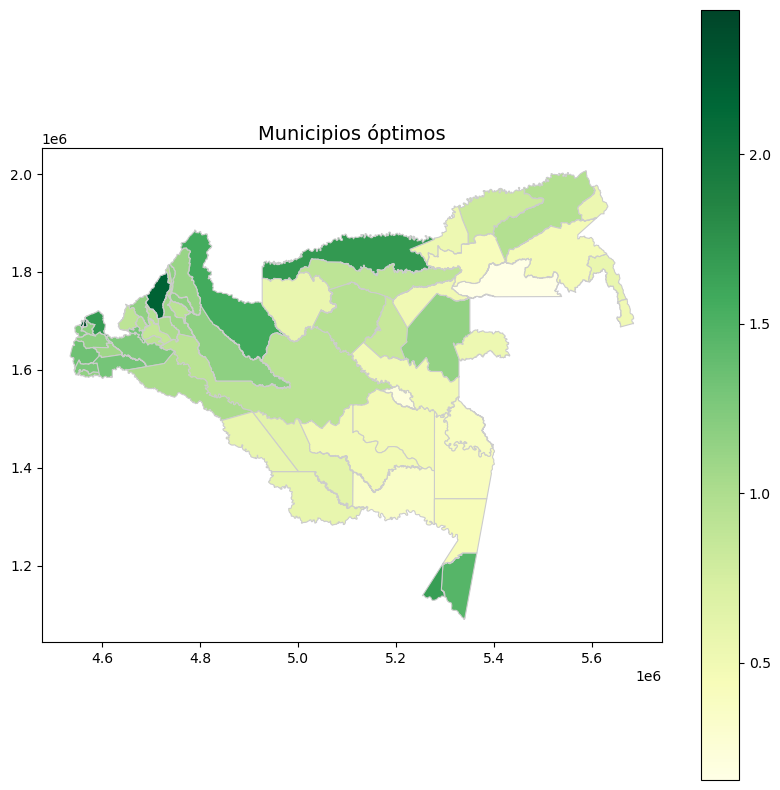

In [313]:
# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa de coropletas
gdf_criterios.plot(column="puntaje_total", 
                 cmap="YlGn", 
                 linewidth=0.8, 
                 edgecolor="0.8", 
                 legend=True, 
                 ax=ax)
# 4. Títulos y estilo
ax.set_title("Municipios óptimos", fontsize=14)
ax.axis("on")

# Agregar grilla 
ax.grid(True, which='both', linestyle='', linewidth=0.5)

plt.show()

#### 🏆 Selección del Municipio Óptimo
Después de normalizar y ponderar todos los criterios espaciales y socioeconómicos relevantes, se procede a seleccionar el municipio que presenta las condiciones más favorables para establecer un centro de acopio agrícola.

📌 Criterios considerados:
- Densidad vial (C_vias): se priorizan municipios con mayor accesibilidad.

- Proporción de áreas protegidas (C_runap): se favorecen zonas con menor proporción de restricciones por conservación.

- Número de estaciones meteorológicas (C_estaciones): útil para monitoreo ambiental.

- Producción agrícola total (C_Produccion): refleja el potencial productivo.

- Variedad de cultivos (C_cultivos y C_variedad): se buscan municipios con diversidad agrícola.

- Densidad poblacional (C_poblacion): se valora una mayor cercanía a núcleos de población por razones logísticas.

In [314]:
mun_opt = gdf_criterios.sort_values(by='puntaje_total', ascending=False).head(1)

print(mun_opt)

   DPTO_CCDGO MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
19         86      86749   SIBUNDOY      86749     2018  9.773462e+07   

     LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  Producción\n(t)  \
19  1.228747 -76.913076      7446.0      432.0  ...          20565.0   

    n_cultivos    C_vias  C_runap  C_estaciones  C_Produccion  C_cultivos  \
19        18.0  0.591138      1.0      0.108108      0.037932    0.352941   

    C_poblacion  C_variedad  puntaje_total  
19          1.0    0.352941       2.424855  

[1 rows x 111 columns]


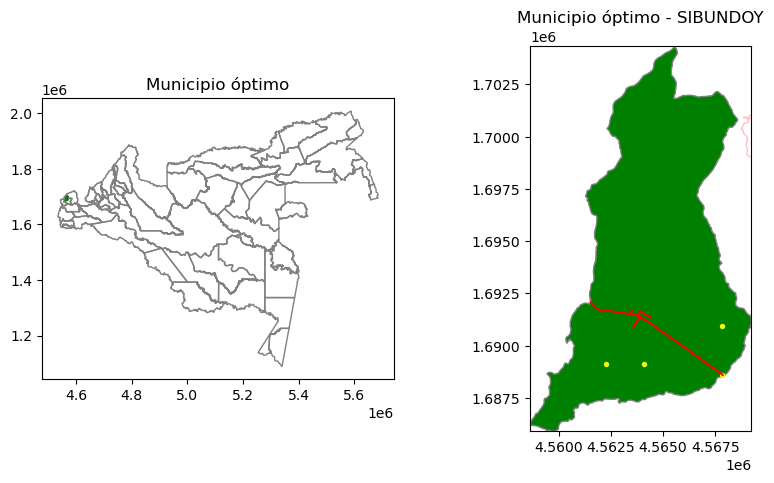

In [315]:
vias_mun = gpd.overlay(vias_en_mun, mun_opt, how='intersection')
est_mun = gpd.overlay(est_en_mun, mun_opt, how='intersection')

# Visualizar municipio más óptimmo
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

gdf_criterios.plot(ax=ax1, color="none", edgecolor="gray", figsize=(5, 5))
mun_opt.plot(ax=ax1, color="green", edgecolor="green", figsize=(5, 5))

# 4. Títulos y estilo
ax1.set_title("Municipio óptimo")
# plt.show()

mun_opt.plot(ax=ax2, color="green", edgecolor="grey", figsize=(5, 5))
est_mun.plot(ax=ax2, color="yellow", markersize=8);
interseccion_runap.plot(ax=ax2, color='None', edgecolor='pink');
vias_mun.plot(ax=ax2, edgecolor='red');

# Establecer límites del mapa con base en el municipio óptimo
ax2.set_xlim(mun_opt.total_bounds[0], mun_opt.total_bounds[2])
ax2.set_ylim(mun_opt.total_bounds[1], mun_opt.total_bounds[3])

ax2.set_title("Municipio óptimo - SIBUNDOY")
plt.show()

## Core analysis steps — Level 2: Best location within selected municipality

#### 🔲 Generación de Grilla Regular dentro del Municipio Óptimo
Una vez seleccionado el municipio más apto, se procede a realizar un análisis de nivel 2 (intra-municipal), para identificar el área óptima donde establecer el centro de acopio agrícola. Este análisis se basa en una división espacial uniforme mediante una grilla de resolución definida.

In [316]:
import numpy as np

# Bounds of the municipalities layer
bounds = mun_opt.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 100 km x 100 km grid → 100_000 m)
res = 1000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_mun.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()

,geometry,id
0,"POLYGON ((4558631 1704907, 4559631 1704907, 45...",0
1,"POLYGON ((4558631 1703907, 4559631 1703907, 45...",1
2,"POLYGON ((4558631 1702907, 4559631 1702907, 45...",2
3,"POLYGON ((4558631 1701907, 4559631 1701907, 45...",3
4,"POLYGON ((4558631 1700907, 4559631 1700907, 45...",4


#### 🧮 Preparación de Atributos del Municipio Óptimo
Antes de realizar el análisis espacial detallado dentro del municipio seleccionado, es importante calcular y agregar atributos clave que servirán como insumos o contexto para la siguiente fase del estudio.

In [317]:
#  Prepare the municipalities layer: add 'area' attribute

# Calculate polygon area in square metres
mun_opt['area_m2'] = mun_opt.area

# Example variable to transfer: let's simulate that each municipality has an attribute 'population'
# For this example only: we'll assign a dummy population proportional to area (you can replace it with real data)
mun_opt['population'] = mun_opt['area_m2'] / 1e6  # arbitrary example: 1 person per km²

# View sample
mun_opt[['MPIO_CNMBR', 'area_m2', 'population']].head()


,MPIO_CNMBR,area_m2,population
19,SIBUNDOY,9.779632e+07,97.796319


#### 🗺️ División Espacial del Municipio Óptimo: Análisis Intra-Municipal
Con el municipio óptimo ya seleccionado, el siguiente paso es subdividir su territorio en unidades espaciales más pequeñas (por ejemplo, celdas de una grilla regular) que permitan evaluar de manera detallada los criterios de localización para el centro de acopio agrícola.

In [318]:
#  Overlay operation: split municipalities by grid cells

mun_grid = mun_opt.overlay(grid)

# Keep only needed columns
mun_grid = mun_grid[['id', 'area_m2', 'population', 'geometry']]

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()

,id,area_m2,population,geometry,area_sub
0,16,9.779632e+07,97.796319,"POLYGON ((4559531.698 1687922.509, 4559521.689...",81135.717596
1,17,9.779632e+07,97.796319,"POLYGON ((4559095.609 1686973.644, 4559141.467...",297923.202588
2,18,9.779632e+07,97.796319,"POLYGON ((4559590.341 1685954.572, 4559543.238...",713298.204998
3,33,9.779632e+07,97.796319,"POLYGON ((4560528.028 1690938.793, 4560521.73 ...",43583.029317
4,34,9.779632e+07,97.796319,"POLYGON ((4560612.96 1690239.796, 4560584.34 1...",112628.469795


#### 🖼️ Visualización de la Grilla Intersectada con el Municipio Óptimo
Se genera un mapa para representar gráficamente las subdivisiones espaciales (celdas) obtenidas tras la operación de overlay entre el municipio seleccionado y la grilla regular.

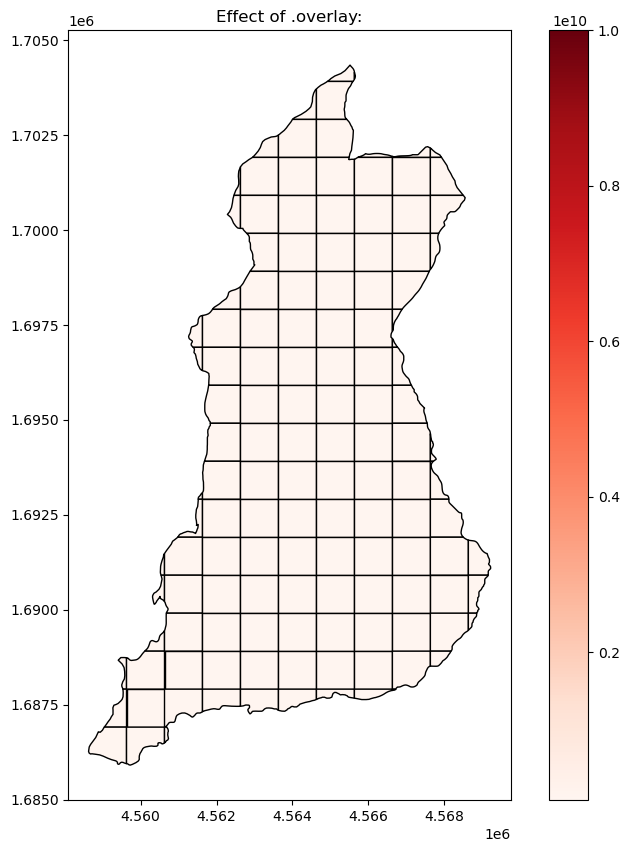

In [319]:
# Plot the result

ax = mun_grid.plot(
    column='area_sub',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=100000000,
    vmax=10000000000
)

# Title
plt.title("Effect of .overlay:")
plt.show()

#### 📐 Cálculo de proporción de área y población corregida por celda
Después de dividir el municipio óptimo en una grilla, se calcula qué proporción del área del municipio representa cada celda y se estima la población correspondiente en función de esa proporción.

In [320]:
# Compute area proportion and corrected population per piece

mun_grid['area_prop'] = mun_grid['area_sub'] / mun_grid['area_m2']
mun_grid['population_part'] = mun_grid['population'] * mun_grid['area_prop']

mun_grid

,id,area_m2,population,geometry,area_sub,area_prop,population_part
0,16,9.779632e+07,97.796319,"POLYGON ((4559531.698 1687922.509, 4559521.689...",81135.717596,0.000830,0.081136
1,17,9.779632e+07,97.796319,"POLYGON ((4559095.609 1686973.644, 4559141.467...",297923.202588,0.003046,0.297923
2,18,9.779632e+07,97.796319,"POLYGON ((4559590.341 1685954.572, 4559543.238...",713298.204998,0.007294,0.713298
3,33,9.779632e+07,97.796319,"POLYGON ((4560528.028 1690938.793, 4560521.73 ...",43583.029317,0.000446,0.043583
4,34,9.779632e+07,97.796319,"POLYGON ((4560612.96 1690239.796, 4560584.34 1...",112628.469795,0.001152,0.112628
...,...,...,...,...,...,...,...
126,195,9.779632e+07,97.796319,"POLYGON ((4568601.701 1689428.726, 4568583.494...",847030.726060,0.008661,0.847031
127,196,9.779632e+07,97.796319,"POLYGON ((4568171.317 1688902.218, 4568164.261...",153386.980646,0.001568,0.153387
128,213,9.779632e+07,97.796319,"POLYGON ((4568646.916 1691827.95, 4568648.528 ...",414021.385582,0.004234,0.414021
129,214,9.779632e+07,97.796319,"POLYGON ((4569152.311 1690905.302, 4569151.056...",319586.818705,0.003268,0.319587


#### 🧮 Agregación de población por celda de grilla
Tras calcular la población proporcional de cada celda en la intersección del municipio óptimo con la grilla, se agregan estos valores para obtener el total de población estimada por cada celda del grid.

In [321]:
# Aggregate to grid

# Sum the partial populations per grid cell
grid_population = mun_grid.groupby('id')['population_part'].sum().reset_index()

# Join the result back to the grid
grid = pd.merge(grid, grid_population, on='id', how='left')


                                              geometry   id  population_part
71   POLYGON ((4561631 1690907, 4562631 1690907, 45...   74              1.0
54   POLYGON ((4560631 1688907, 4561631 1688907, 45...   56              1.0
36   POLYGON ((4559631 1687907, 4560631 1687907, 45...   37              1.0
149  POLYGON ((4565631 1688907, 4566631 1688907, 45...  156              1.0
155  POLYGON ((4566631 1701907, 4567631 1701907, 45...  163              1.0
..                                                 ...  ...              ...
201  POLYGON ((4568631 1693907, 4569631 1693907, 45...  211              NaN
202  POLYGON ((4568631 1692907, 4569631 1692907, 45...  212              NaN
206  POLYGON ((4568631 1688907, 4569631 1688907, 45...  216              NaN
207  POLYGON ((4568631 1687907, 4569631 1687907, 45...  217              NaN
208  POLYGON ((4568631 1686907, 4569631 1686907, 45...  218              NaN

[209 rows x 3 columns]


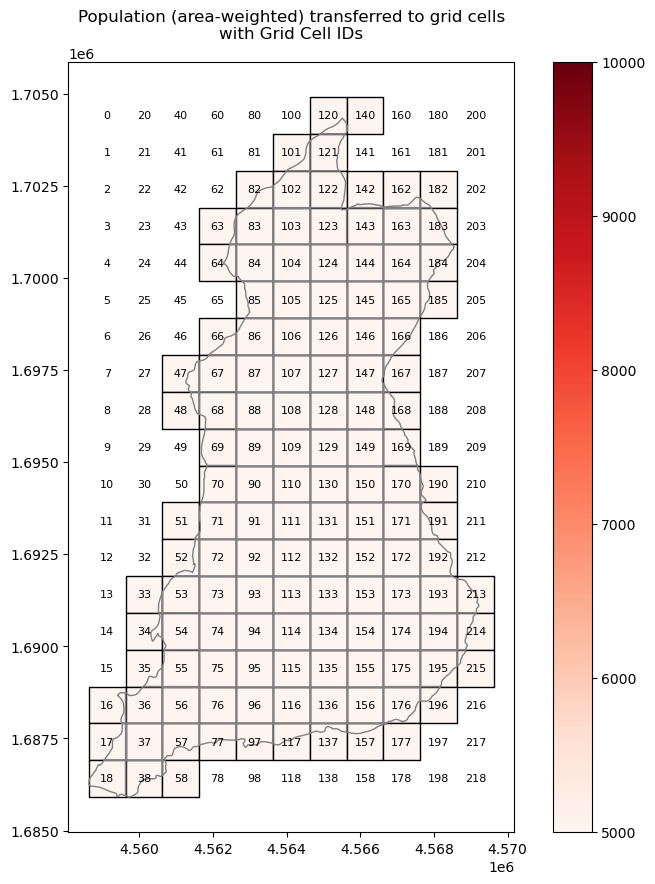

In [322]:
# Plot the result
print(grid.sort_values(by=['population_part'],ascending=False))
ax = grid.plot(
    column='population_part',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=5000,
    vmax=10000
)

# Overlay the municipality boundaries
mun_grid.plot(ax=ax, color='none', edgecolor='grey')

# Add ID labels at centroid of each grid cell
for idx, row in grid.iterrows():
    # Compute centroid of the polygon
    centroid = row['geometry'].centroid
    # Draw text label at the centroid coordinates
    ax.text(
        centroid.x, centroid.y, 
        str(row['id']), 
        ha='center', va='center', 
        fontsize=8, color='black'
    )

# Title
plt.title("Population (area-weighted) transferred to grid cells\nwith Grid Cell IDs")
plt.show()

# Generar zonas de influencia (buffers)

#### 🚧 Análisis de Accesibilidad: Buffers a Infraestructura
Para evaluar la accesibilidad dentro del municipio óptimo seleccionado, se generaron zonas de influencia mediante buffers alrededor de las vías y estaciones meteorológicas.

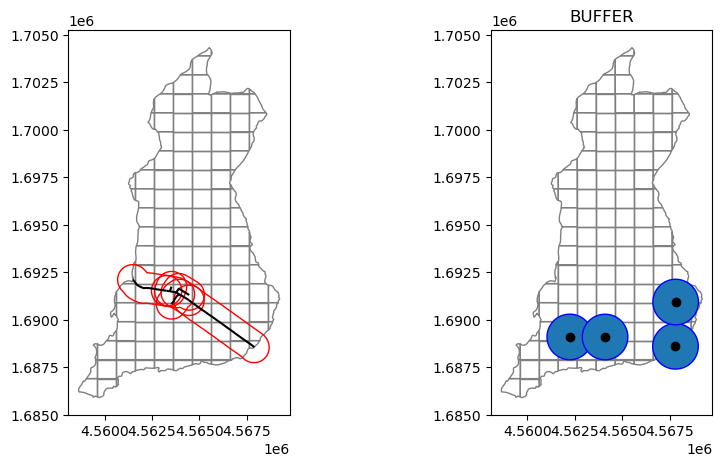

In [323]:
vias_buffer = vias_mun.buffer(800)  # 2 km a vías
est_buffer = est_mun.buffer(1200)  # 3 km a estaciones

fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

mun_grid.plot(ax=ax1, color='none', edgecolor='grey')
vias_buffer.plot(ax=ax1, color='none', edgecolor='red')
vias_mun.plot(ax=ax1, edgecolor='black')

mun_grid.plot(ax=ax2, color='none', edgecolor='grey')
est_buffer.plot(ax=ax2, edgecolor='blue')
est_mun.plot(ax=ax2, color='black', edgecolor='black')

plt.title("BUFFER")
plt.show()

#### 🔍 Priorización Intra-Municipal: Evaluación de Celdas Espaciales
Con el objetivo de identificar el área más adecuada (≤ 5 km²) dentro del municipio óptimo, se aplicó un análisis multicriterio espacial a las celdas generadas con grilla regular. Los criterios evaluados fueron:

- Accesibilidad a vías (≤ 2 km)

- Accesibilidad a estaciones meteorológicas (≤ 3 km)

- Población relativa (ponderada por proporción de área)

In [324]:
# 1. Crear columnas binarias para cada criterio
mun_grid['cerca_vias'] = mun_grid.intersects(vias_buffer.unary_union)
mun_grid['cerca_estaciones'] = mun_grid.intersects(est_buffer.unary_union)

# 2. Convertir booleanos a enteros
mun_grid['cerca_vias'] = mun_grid['cerca_vias'].astype(int)
mun_grid['cerca_estaciones'] = mun_grid['cerca_estaciones'].astype(int)

# 2. Ponderar o sumar criterios (puedes cambiar pesos si lo deseas)
mun_grid['score'] = mun_grid['cerca_vias'] + mun_grid['cerca_estaciones']

# 4. Filtrar celdas menores o iguales a 5 km² (5,000,000 m²)
mun_grid_filtrado = mun_grid[mun_grid['area_prop'] <= 5_000_000]

# Normalización directa, porque más población es mejor
pob_max = mun_grid['population_part'].max()
mun_grid['pob_score'] = mun_grid['population_part'] / pob_max

mun_grid

/tmp/ipykernel_43/4256822737.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mun_grid['cerca_vias'] = mun_grid.intersects(vias_buffer.unary_union)
/tmp/ipykernel_43/4256822737.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mun_grid['cerca_estaciones'] = mun_grid.intersects(est_buffer.unary_union)


,id,area_m2,population,geometry,area_sub,area_prop,population_part,cerca_vias,cerca_estaciones,score,pob_score
0,16,9.779632e+07,97.796319,"POLYGON ((4559531.698 1687922.509, 4559521.689...",81135.717596,0.000830,0.081136,0,0,0,0.081136
1,17,9.779632e+07,97.796319,"POLYGON ((4559095.609 1686973.644, 4559141.467...",297923.202588,0.003046,0.297923,0,0,0,0.297923
2,18,9.779632e+07,97.796319,"POLYGON ((4559590.341 1685954.572, 4559543.238...",713298.204998,0.007294,0.713298,0,0,0,0.713298
3,33,9.779632e+07,97.796319,"POLYGON ((4560528.028 1690938.793, 4560521.73 ...",43583.029317,0.000446,0.043583,0,0,0,0.043583
4,34,9.779632e+07,97.796319,"POLYGON ((4560612.96 1690239.796, 4560584.34 1...",112628.469795,0.001152,0.112628,0,0,0,0.112628
...,...,...,...,...,...,...,...,...,...,...,...
126,195,9.779632e+07,97.796319,"POLYGON ((4568601.701 1689428.726, 4568583.494...",847030.726060,0.008661,0.847031,1,1,2,0.847031
127,196,9.779632e+07,97.796319,"POLYGON ((4568171.317 1688902.218, 4568164.261...",153386.980646,0.001568,0.153387,1,1,2,0.153387
128,213,9.779632e+07,97.796319,"POLYGON ((4568646.916 1691827.95, 4568648.528 ...",414021.385582,0.004234,0.414021,0,1,1,0.414021
129,214,9.779632e+07,97.796319,"POLYGON ((4569152.311 1690905.302, 4569151.056...",319586.818705,0.003268,0.319587,0,1,1,0.319587


#### 🟦 Selección de la Celda Óptima Intra-Municipal
A partir de los criterios espaciales y de población ponderada, se construyó un índice de priorización para cada celda dentro del municipio previamente identificado como óptimo. La lógica combinó:

- Proximidad a vías de comunicación

- Cercanía a estaciones meteorológicas

- Mayor población relativa (normalizada)

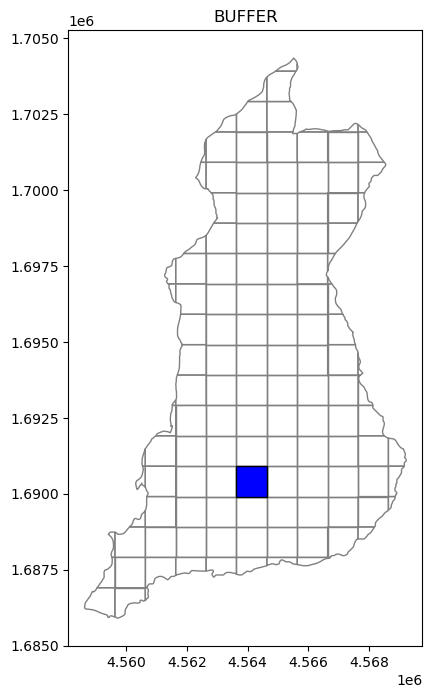

In [325]:
mun_grid['score'] = (
    mun_grid['cerca_vias'] * 1 +
    mun_grid['cerca_estaciones'] * 1 +
    mun_grid['pob_score'] * 1 
)

# Filtrar por área máxima permitida (≤ 5 km²)
# mun_grid_filtrado = mun_grid[mun_grid['area_sub'] <= 5_000_000]

# Seleccionar celda con mayor puntaje
mejor_celda = mun_grid_filtrado.sort_values("score", ascending=False).head(1)

ax = mun_grid.plot(color='none', edgecolor='grey')
mejor_celda.plot(ax=ax, color='blue', edgecolor='black')

plt.title("BUFFER")
plt.show()